In [38]:
import tensorflow as tf

import matplotlib
import matplotlib.pyplot as plt

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
buffer_size = 2
batch_size = 2
num_parallel_batches = 2

def map_fn(image, label):
    return image, label
    

def input_fn():
    d1 = tf.reshape(
        tf.range(4*3),
        (4, 3)
    )
    d2 = tf.range(4)
    dataset = tf.data.Dataset.from_tensor_slices((d1, d2))
    
    dataset = (
        dataset
        .apply(tf.contrib.data.shuffle_and_repeat(buffer_size))
        .apply(tf.contrib.data.map_and_batch(map_fn, batch_size, num_parallel_batches))
    )
    
    iterator = dataset.make_one_shot_iterator()
#     return iterator
    return iterator.get_next()

In [3]:
with tf.Session() as sess:
    next_batch = input_fn()
    
    for i in range(6):
        if i % 2 == 0:
            print('---')
        print(sess.run(next_batch))
        
    next_batch2 = input_fn()
    
    print('\n****** next_batch2 ******\n')
    for i in range(6):
        if i % 2 == 0:
            print('---')
        print(sess.run(next_batch2))

# dataset = tf.data.Dataset.from_tensor_slices((
#     tf.random_uniform([4, 10], maxval=100, dtype=tf.int32),  # train data
#     tf.random_uniform([4])  # train label
# ))

Instructions for updating:
Use the retry module or similar alternatives.
---
(array([[3, 4, 5],
       [0, 1, 2]], dtype=int32), array([1, 0], dtype=int32))
(array([[ 9, 10, 11],
       [ 6,  7,  8]], dtype=int32), array([3, 2], dtype=int32))
---
(array([[0, 1, 2],
       [3, 4, 5]], dtype=int32), array([0, 1], dtype=int32))
(array([[ 9, 10, 11],
       [ 6,  7,  8]], dtype=int32), array([3, 2], dtype=int32))
---
(array([[0, 1, 2],
       [6, 7, 8]], dtype=int32), array([0, 2], dtype=int32))
(array([[ 3,  4,  5],
       [ 9, 10, 11]], dtype=int32), array([1, 3], dtype=int32))

****** next_batch2 ******

---
(array([[0, 1, 2],
       [3, 4, 5]], dtype=int32), array([0, 1], dtype=int32))
(array([[ 9, 10, 11],
       [ 6,  7,  8]], dtype=int32), array([3, 2], dtype=int32))
---
(array([[3, 4, 5],
       [6, 7, 8]], dtype=int32), array([1, 2], dtype=int32))
(array([[ 9, 10, 11],
       [ 0,  1,  2]], dtype=int32), array([3, 0], dtype=int32))
---
(array([[0, 1, 2],
       [6, 7, 8]], dtype=i

In [ ]:
def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((
        tf.random_uniform([4, 10], maxval=100, dtype=tf.int32),  # train data
        tf.random_uniform([4])  # train label
    ))
    
    
    
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

In [5]:
def model_fn(features, labels, mode, params):
    return tf.estimator.EstimatorSpec(mode)

In [6]:
estimator = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpsxbk1xuu', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fe7f7256240>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [2]:
estimator.train(input_fn, steps=1)

In [3]:
import os

In [8]:
print(os.environ.get('hello_world_env'))

None


In [1]:
import logging

In [ ]:
logging.FileHandler()

# Model Ensemble

In [3]:
import os
import importlib
import tqdm

MODEL_DIR_PREFIX = '/home/shared/cs231n-fashion/model_dir'

def write_predictions(probs):
    """
    Inputs:
        probs: 
    
    Globals:
        FLAGS.test_prediction
        FLAGS.pred_threshold
    """
    print("Saving test data to: ", FLAGS.test_prediction)
    f = open(FLAGS.test_prediction, "w")
    f.write("image_id,label_id\n")
    img_id = 1

    # deal with unified threshold or per class thresholding
    thresholds = []
    if re.match("^\d+?\.\d+?$", FLAGS.pred_threshold) is None:
        print("Use per class thresholding.")
        thresholds = pd.read_csv(FLAGS.pred_threshold)['thresholds'].values
    else:
        th = float(FLAGS.pred_threshold)
        thresholds = [th for i in range(228)]

    with tqdm(total=NUM_TEST) as progress_bar:
        for prob in probs:
            labels=" ".join([
                str(i+1)
                for i in range(len(prob))
                if prob[i] >= thresholds[i]
            ])
            f.write("%d,%s\n"%(img_id, labels))
            img_id += 1
            progress_bar.update(1)
    print("Processed %d examples. Good Luck! :)"%(img_id))
    f.close()
    

def predict_with_ensemble(ensemble_label_to_model_meta, run_config, params, test_input_fn):
    """
    Inputs:
        ensemble_label_to_model_meta: dict. KV is in the following format:
            'label': ('model_file', 'exp_name', weight).
            The model_file should export model_fn(features, labels, mode, params).
            The exp_name should be the folder name that stores the weights of the model.
    """
    # Validate existence of exp_names.

    total_weight = 0.0
    agg_probs = None

    for label in ensemble_label_to_model_meta:
        model_file, exp_name, weight = ensemble_label_to_model_meta[label]
        model_dir = os.path.join(MODEL_DIR_PREFIX, exp_name)

        # Create model from model_file.
        model_fn = importlib.import_module(model_file).model_fn

        # Initialize classifier with weights from exp_name.
        classifier = tf.estimator.Estimator(
            config=run_config,
            model_fn=model_fn,
            model_dir=model_dir,
            params=params
        )

        # Make predictions.
        probs = [pred['probs'] for pred in classifier.predict(test_input_fn)]
        
        # Aggregate weighted probs.
        if agg_probs is None:
            agg_probs = weight * probs
        else:
            agg_probs += weight * probs
        total_weight += weight
    
    agg_probs /= total_weight
    write_predictions(agg_probs)

In [ ]:
# KV is 'label': ('model_file', 'exp_name', weight)
ensemble_label_to_model_meta = {
    'label1': ['base', 'exp1', 0.2],
    'label2': ['base', 'exp2', 0.5],
}

run_config = tf.estimator.RunConfig(
    session_config=tf.ConfigProto(log_device_placement=True),
#             save_checkpoints_secs=30*60,
#             keep_checkpoint_max=10,
)

params = {
    'learning_rate': FLAGS.learning_rate,
    'num_classes': FLAGS.num_classes,
    'module_trainable': FLAGS.module_trainable,
    'eval_thresholds': [float(i) for i in FLAGS.eval_thresholds.split(';')],
    'model_dir': FLAGS.model_dir,
    'reg': FLAGS.reg,
}

In [2]:
import logging

In [4]:
log = logging.getLogger('tensorflow')

In [9]:
stdout_handler = log.handlers[0]

In [10]:
log.removeHandler(stdout_handler)

# Test ensemble

1. Read csv file using pandas
2. 

In [11]:
import pandas as pd

In [19]:
import numpy as np
import pandas as pd
import os

prob_dir = '/home/minfa/ensemble_dir'
prob_files = os.listdir(prob_dir)
agg_probs = None

for prob_file in prob_files:
    prob_file_path = os.path.join(prob_dir, prob_file)
    print("Reading data from: {}".format(prob_file_path))
    
    probs = pd.read_csv(prob_file_path)['label_prob'].map(lambda x: np.array([float(v) for v in x.split(' ')])).values
    probs = np.array(probs.tolist())
    if agg_probs is None:
        agg_probs = probs
    else:
        agg_probs += probs

agg_probs /= len(prob_files)

Reading data from: /home/minfa/ensemble_dir/debug_dump_test.csv
Reading data from: /home/minfa/ensemble_dir/debug_dump_test2.csv


In [12]:
import tensorflow as tf

In [17]:
tf.logging.warn('hello')

hello


In [3]:
import logging

In [6]:
tf_logger = logging.getLogger('tensorflow')

In [9]:
tf_logger.removeHandler(tf_logger.handlers[0])

In [ ]:
tf_logger.

In [16]:
tf_logger.setLevel('WARN')

In [2]:
from keras.applications.xception import Xception

In [3]:
base_model = Xception(weights='imagenet', include_top=False)

83689472/83683744 [==============================] - 4s 0us/step


In [10]:
act_layer = base_model.layers[119]

In [3]:
act_layer.

SyntaxError: invalid syntax (<ipython-input-3-c69f2f0ce3a6>, line 1)

# Keras image generator

In [1]:
from utils.keras_image import ImageDataGenerator

/home/minfa/.local/share/virtualenvs/cs231n-fashion-rD9JfZw-/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [4]:
import os
# Use absolute path for root. It will be joined by other relative paths.
ROOT = '/home/minfa/cs231n-fashion'
train_label_to_weight_map_path = os.path.join(ROOT, 'data/train_label_to_weight_map.json')
train_labels_count_to_weight_map_path = os.path.join(ROOT, 'data/train_labels_count_to_weight_map.json')

In [5]:
generator_params = {
    'generator_use_wad': False,
    'generator_use_weight': True,
    'train_label_to_weight_map_path': train_label_to_weight_map_path,
    'train_labels_count_to_weight_map_path': train_labels_count_to_weight_map_path,
}

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    vertical_flip=True,
    is_training=True,
    params=generator_params)

In [14]:
import json

train_data_dir = '/home/fashion/data/train_processed'
train_label = '/home/fashion/data/train.json'
num_classes = 228
IMG_SIZE = 299
batch_size = 64


def load_labels(json_path):
    labelIds = {}
    with open(json_path, 'r') as f:
        data = json.load(f)
        for label_data in data["annotations"]:
            imgId = label_data["imageId"]
            labelId = [int(x) for x in label_data["labelId"]]
            labelIds[imgId] = labelId
    return labelIds

train_label_map = load_labels(json_path=train_label)
train_generator = train_datagen.flow_from_directory(train_data_dir,
                                                    classes=range(num_classes),
                                                    target_size=(IMG_SIZE, IMG_SIZE),
                                                    batch_size=batch_size,
                                                    class_mode='multilabel',
                                                    multilabel_classes=train_label_map)

Found 1012935 images belonging to 228 classes.


In [20]:
batches100 = [train_generator.next() for _ in range(100)]

In [21]:
next_batch = batches100[0]
batch_inputs, batch_labels, batch_weights = next_batch

print(batch_inputs.shape)
print(batch_labels.shape)
print(batch_weights.shape)

(64, 299, 299, 3)
(64, 228)
(64,)


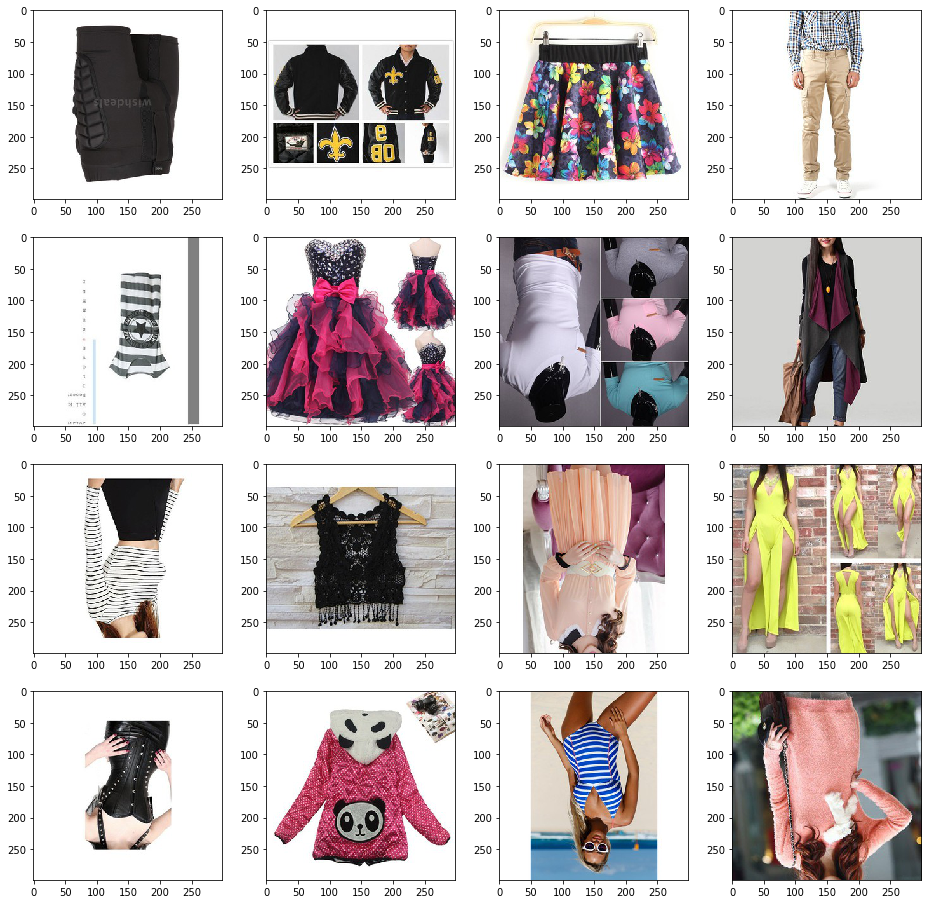

In [92]:
import numpy as np
import matplotlib.pyplot as plt

nrows = 4
ncols = 4

sampled_batch = batches100[np.random.randint(low=0, high=100)]
batch_inputs, batch_labels, batch_weights = sampled_batch

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
batch_sample_indices = np.random.choice(batch_inputs.shape[0], size=nrows*ncols, replace=False)
batch_sample_inputs = batch_inputs[batch_sample_indices]
assert batch_sample_inputs.shape == (nrows * ncols, 299, 299, 3)

for i in range(nrows):
    for j in range(ncols):
        k = i * ncols + j
        img = batch_sample_inputs[k]
        ax[i, j].imshow(img)

# Color histogram with white background dropped

### Need to run the Keras image generator cells above to get batch_sample_inputs

(array([ 196366.,  215302.,  183867.,  128577.,  197986.,  216932.,
         330490.,  466215.,  683906., 1671607.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

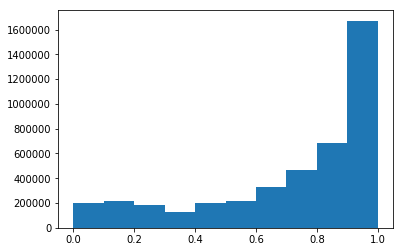

In [29]:
plt.hist(np.ravel(batch_sample_inputs))

In [30]:
import utils.keras_image as gen_utils

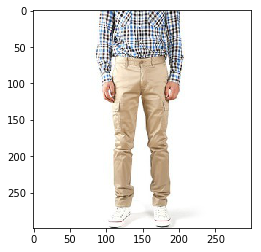

In [93]:
sample_input = batch_sample_inputs[3]
plt.imshow(sample_input)

In [66]:
sample_chist = gen_utils.color_histogram_hsv(sample_input, nbin=10, xmin=0.0, xmax=1.0)
print('sum: {}'.format(np.sum(sample_chist)))

sum: 1.0


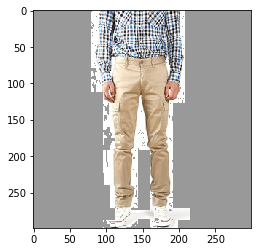

In [94]:
def create_zero_hue_mask(image):
    """
    Image: shape (299, 299, 3). Value in range [0, 1].
    """
    hsv = matplotlib.colors.rgb_to_hsv(image)
    hue = hsv[:, :, 0]
    
    masked_image = image.copy()
    masked_image[hue == 0] = 0.6
    return masked_image

#     plt.hist(np.ravel(hue))
#     plt.hist(np.ravel(hue[np.nonzero(hue)]))

#     image_mask = np.zeros(shape=(299, 299, 3))
#     image_mask[np.nonzero(hue)] = 0.6
#     return image_mask

plt.imshow(sample_input)
plt.imshow(create_zero_hue_mask(sample_input))

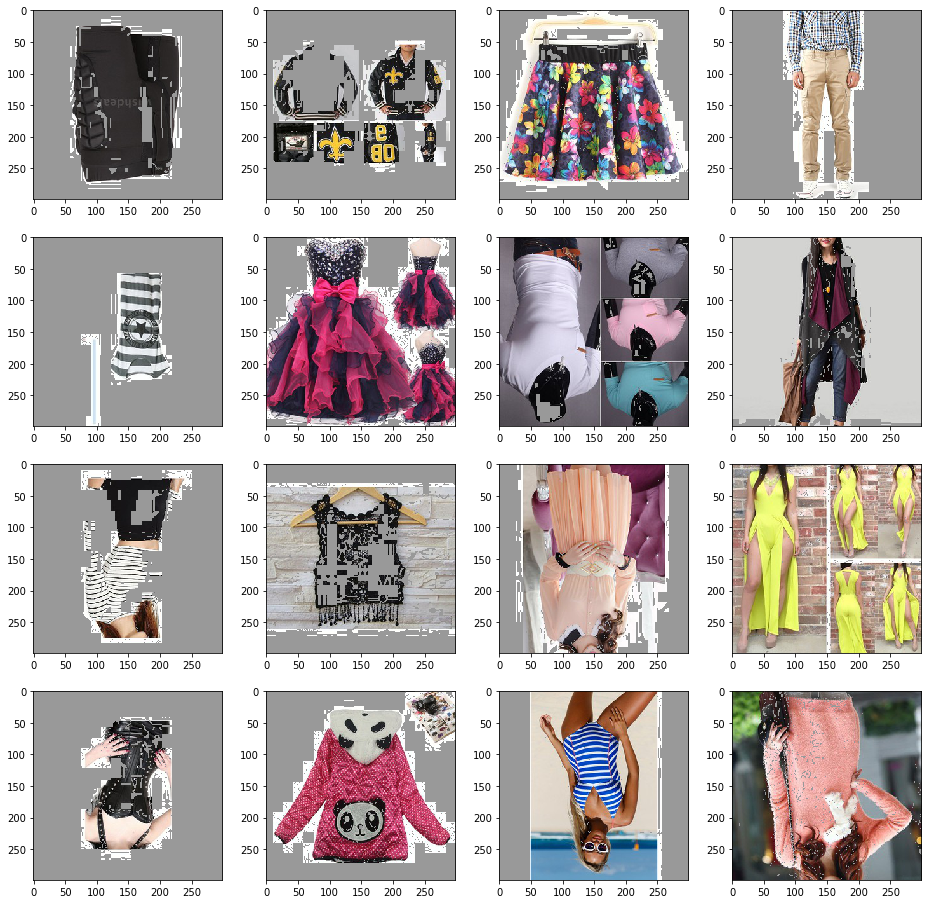

In [95]:
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 16))
# batch_sample_indices = np.random.choice(batch_inputs.shape[0], size=nrows*ncols, replace=False)
# batch_sample_inputs = batch_inputs[batch_sample_indices]
assert batch_sample_inputs.shape == (nrows * ncols, 299, 299, 3)

for i in range(nrows):
    for j in range(ncols):
        k = i * ncols + j
        img = batch_sample_inputs[k]
        img_mask = create_zero_hue_mask(img)
        ax[i, j].imshow(img_mask)

In [82]:
def color_histogram_hsv(im, nbin=10, xmin=0, xmax=255, normalized=True, ignore_background=True):
    """
    Compute color histogram for an image using hue.
    Inputs:
    - im: H x W x C array of pixel data for an RGB image.
    - nbin: Number of histogram bins. (default: 10)
    - xmin: Minimum pixel value (default: 0)
    - xmax: Maximum pixel value (default: 255)
    - normalized: Whether to normalize the histogram (default: True)
    Returns:
    1D vector of length nbin giving the color histogram over the hue of the
    input image.
    """
    ndim = im.ndim
    bins = np.linspace(xmin, xmax, nbin+1)
    hsv = matplotlib.colors.rgb_to_hsv(im/xmax) * xmax
    hue = hsv[:, :, 0]
    if ignore_background:
        hue = hue[np.nonzero(hue)]

    imhist, bin_edges = np.histogram(hue, bins=bins, density=normalized)
    imhist = imhist * np.diff(bin_edges)

    # return histogram
    return imhist

array([0.38117313, 0.07615894, 0.02133396, 0.00842006, 0.02355724,
       0.06433302, 0.01877956, 0.07762535, 0.05695364, 0.27166509])

In [85]:
sample_chist = color_histogram_hsv(
    sample_input, nbin=10, xmin=0.0, xmax=1.0, ignore_background=False)
print('hist: \n{}'.format(sample_chist))

print('\n')

sample_chist = color_histogram_hsv(
    sample_input, nbin=10, xmin=0.0, xmax=1.0, ignore_background=True)
print('hist no background: \n{}'.format(sample_chist))

hist: 
[0.85367054 0.01800875 0.00504469 0.00199103 0.00557041 0.01521236
 0.00444067 0.0183555  0.01346741 0.06423866]


hist no background: 
[0.38117313 0.07615894 0.02133396 0.00842006 0.02355724 0.06433302
 0.01877956 0.07762535 0.05695364 0.27166509]


# Create per-class F1

In [2]:
# from xception import KerasXception

# params = {
#     'model_dir': '/home/shared/cs231n-fashion/model_dir/keras_xception',
#     'fine_tune': False,
#     'num_classes': 228,
#     'image_size': 299,
#     'reg': 0.0,
# }

# model = KerasXception(params)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, None, None, 3 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, None, None, 3 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [9]:
valid_json_path = '/home/minfa/.kaggle/competitions/imaterialist-challenge-fashion-2018/validation.json'
import json

with open(valid_json_path, 'r') as fin:
    valid_json = json.load(fin)
    
valid_json.keys()

dict_keys(['images', 'annotations'])

In [16]:
assert len(valid_json['images']) == len(valid_json['annotations'])
print('len(valid):{}\n'.format(len(valid_json['annotations'])))
print('example "images" entry:\n{}\n'.format(valid_json['images'][0]))
print('example "annotations" entry:\n{}'.format(valid_json['annotations'][0]))

len(valid):9897

example "images" entry:
{'url': 'https://contestimg.wish.com/api/webimage/568e16a72dfd0133cb3f7a79-large', 'imageId': '1'}

example "annotations" entry:
{'labelId': ['62', '17', '66', '214', '105', '137', '85'], 'imageId': '1'}


In [34]:
valid_truth_img_to_labels_map = {
    int(image['imageId']) : map(int, annotation['labelId'])
    for image, annotation in zip(valid_json['images'], valid_json['annotations'])
}

In [35]:
import csv
# preds_path = '/home/minfa/cs231n-fashion/submission/validation_dir/ssd_xception_valid.csv'
valid_preds_path = '/home/minfa/ssd_xception_valid_labels.csv'
with open(valid_preds_path, 'r') as fin:
    reader = csv.reader(fin)
    next(reader)  # Skip header row.
    
    valid_pred_img_to_labels_map = {
        int(img_id): [int(label) for label in labels_str.split()]
        for img_id, labels_str in reader
    }

In [36]:
assert len(valid_pred_img_to_labels_map) == len(valid_truth_img_to_labels_map)

In [37]:
from collections import defaultdict

def reverse_img_to_labels_map(img_to_labels_map):
    label_to_imgs_map = defaultdict(list)
    for img_id, labels in img_to_labels_map.items():
        for label_id in labels:
            label_to_imgs_map[label_id] += img_id,
    return label_to_imgs_map

valid_pred_label_to_imgs_map = reverse_img_to_labels_map(valid_pred_img_to_labels_map)
valid_truth_label_to_imgs_map = reverse_img_to_labels_map(valid_truth_img_to_labels_map)
print('valid pred labels: {}'.format(len(valid_pred_label_to_imgs_map)))
print('valid truth labels: {}'.format(len(valid_truth_label_to_imgs_map)))

valid pred labels: 164
valid truth labels: 225


In [84]:
def get_f1_for_label(label_id, pred_label_to_imgs_map, truth_label_to_imgs_map):
    """
    Returns:
        (f1, precision, recall)
    """
    if label_id not in truth_label_to_imgs_map:
        print('WARNING: label_id ({}) not in truth map.'.format(label_id))
        return 0.0, 0.0, 0.0
#     assert label_id in truth_label_to_imgs_map, 'label_id ({}) not in truth map.'.format(label_id)
    
    # Precision == 0.
    if label_id not in pred_label_to_imgs_map:
        return 0.0, 0.0, 0.0
    
    truth_imgs = set(truth_label_to_imgs_map[label_id])
    pred_imgs = pred_label_to_imgs_map[label_id]
    
    true_positive_count = len([img_id for img_id in pred_imgs if img_id in truth_imgs])
    precision = true_positive_count * 1.0 / len(pred_imgs)
    recall = true_positive_count * 1.0 / len(truth_imgs)
    
    if precision == 0 and recall == 0:
        return 0.0, 0.0, 0.0
    
    f1 = 2 * (precision * recall) / (precision + recall)
    return f1, precision, recall

for label_id in range(19, 229):
    f1, precision, recall = get_f1_for_label(label_id, valid_pred_label_to_imgs_map, valid_truth_label_to_imgs_map)
    if f1 > 0.5:
        print(label_id, f1, precision, recall)
        break

20 0.5174777244688141 0.8092175777063236 0.380352644836272


In [85]:
import pandas as pd

def create_f1_df(pred_label_to_imgs_map, truth_label_to_imgs_map):
    f1_dict = {
        'label': [],
        'img_count': [],
        'f1': [],
        'precision': [],
        'recall': [],
    }

    for label_id in range(1, 229):
        img_count = len(truth_label_to_imgs_map.get(label_id, []))
        f1, precision, recall = get_f1_for_label(label_id, pred_label_to_imgs_map, truth_label_to_imgs_map)
        
        f1_dict['label'] += label_id,
        f1_dict['img_count'] += img_count,
        f1_dict['f1'] += f1,
        f1_dict['precision'] += precision,
        f1_dict['recall'] += recall,


    f1_df = pd.DataFrame.from_dict(f1_dict)
    return f1_df

f1_df = create_f1_df(valid_pred_label_to_imgs_map, valid_truth_label_to_imgs_map)
f1_df.head()

,label,img_count,f1,precision,recall
0,1,36,0.000000,0.000000,0.000000
1,2,282,0.033003,0.238095,0.017730
2,3,24,0.000000,0.000000,0.000000
3,4,54,0.453782,0.415385,0.500000
4,5,195,0.173913,0.157025,0.194872


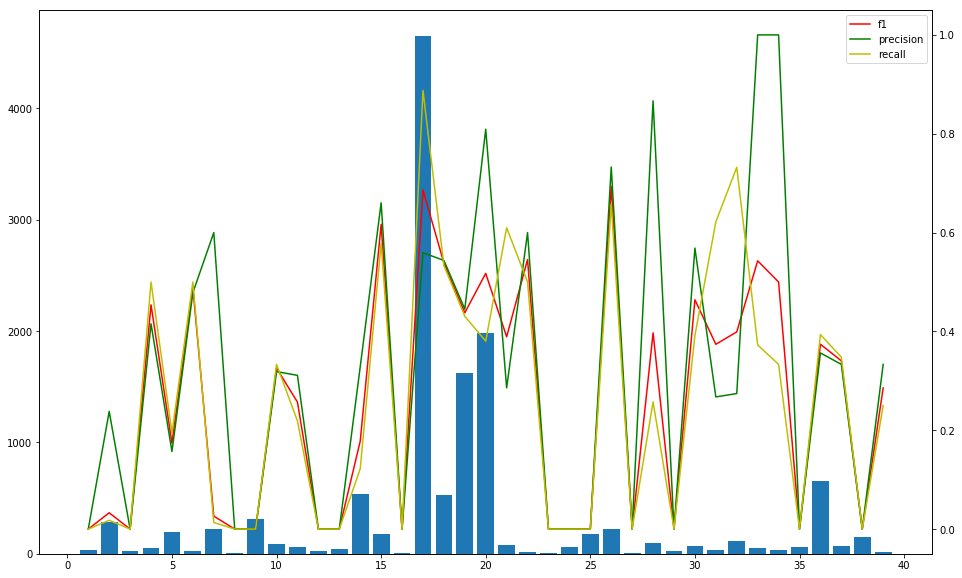

In [92]:
import matplotlib.pyplot as plt

def plot_f1(f1_df):
    plt.figure(figsize=(16, 10))
    plt.bar(f1_df['label'], f1_df['img_count'])
    ax2 = plt.twinx()
    ax2.plot(f1_df['label'], f1_df['f1'], color='r')
    ax2.plot(f1_df['label'], f1_df['precision'], color='g')
    ax2.plot(f1_df['label'], f1_df['recall'], color='y')
    ax2.legend()

plot_f1(f1_df[f1_df['label'] < 40])

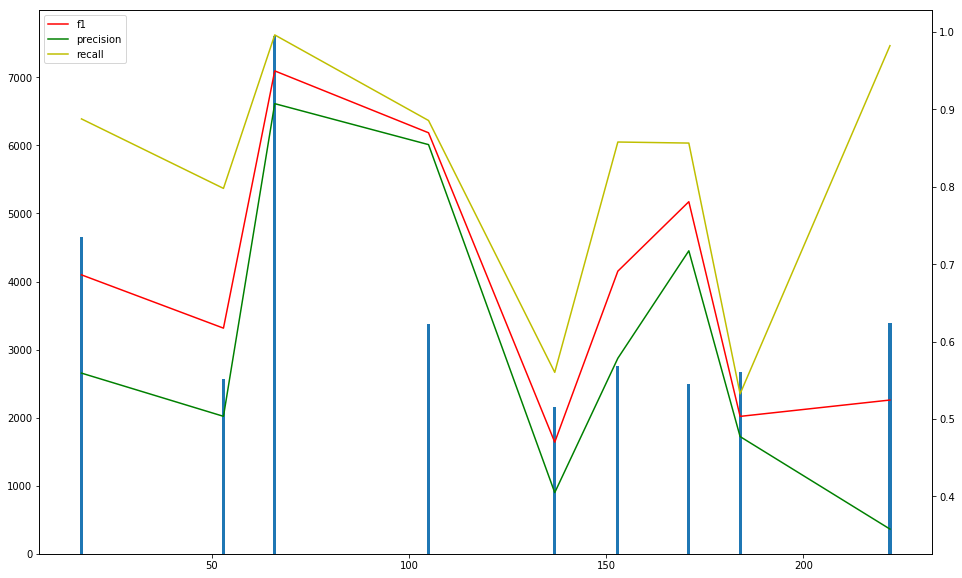

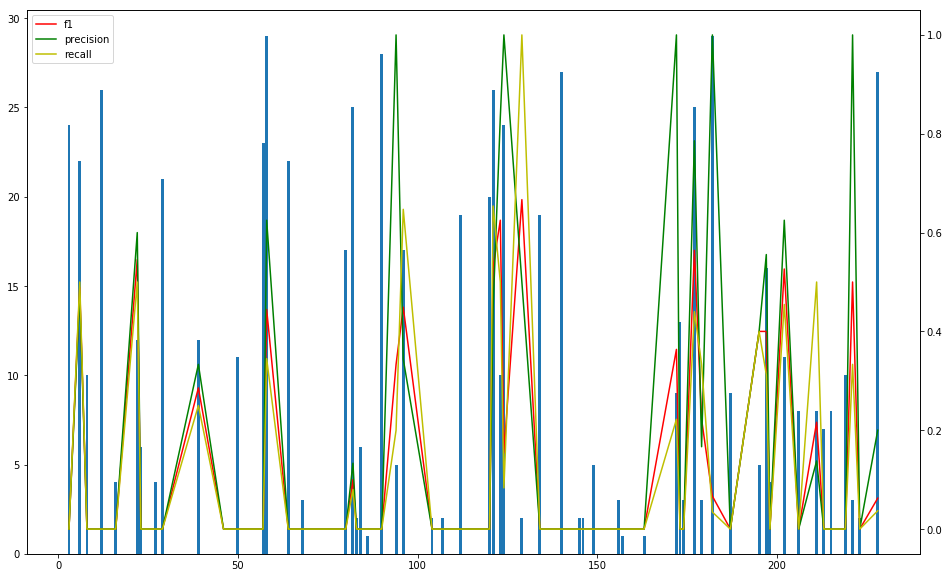

In [93]:
plot_f1(f1_df[f1_df['img_count'] > 2000])
plot_f1(f1_df[f1_df['img_count'] < 30])

# train_label_to_weight_map

In [7]:
train_json_path = '../data/train.json'  # TODO: use real path.
import json

with open(train_json_path, 'r') as fin:
    train_json = json.load(fin)

In [10]:
print('keys:', train_json.keys())
assert len(train_json['images']) == len(train_json['annotations'])
print('len(images):', len(train_json['images']))
print('images[0]:', train_json['images'][0])
print('annotations[0]:', train_json['annotations'][0])

keys: dict_keys(['info', 'images', 'annotations', 'license'])
len(images): 1014544
images[0]: {'url': 'https://contestimg.wish.com/api/webimage/570f35feb2f4b95d223aa9b1-large', 'imageId': '1'}
annotations[0]: {'labelId': ['95', '66', '137', '70', '20'], 'imageId': '1'}


In [12]:
from collections import Counter
def get_label_to_freq_map(data_json):
    label_to_freq_map = Counter()
    for _, annotation in zip(data_json['images'], data_json['annotations']):
#         imag_id = int(annotation['imageId'])
        label_ids = map(int, annotation['labelId'])
        for label_id in label_ids:
            label_to_freq_map[label_id] += 1
    return label_to_freq_map
    

train_label_to_freq_map = get_label_to_freq_map(train_json)

In [37]:
def normalize_label_to_freq_map(label_to_freq_map, alpha=0.75):
    """
    Inputs:
        label_to_freq_map: dict of (label: int, freq: int) pairs.
    
    Returns:
        dict of (label: int, normalized_weight: float) pairs.
    """
    freqs = label_to_freq_map.values()
    freq_max = max(freqs)
    
    label_to_weight_map = {}
    total_adjusted_freq = 0.0
    for label, freq in label_to_freq_map.items():
        adjusted_freq = (1.0 * freq / freq_max) ** alpha
        weight = adjusted_freq / freq
        label_to_weight_map[label] = weight
        total_adjusted_freq += adjusted_freq

#     raw_weight_sum = sum(label_to_weight_map.values())
#     norm_ratio = num_images / raw_weight_sum
    norm_ratio = sum(freqs) / total_adjusted_freq
    
    for label, weight in label_to_weight_map.items():
        label_to_weight_map[label] = weight * norm_ratio

    return label_to_weight_map

test_label_to_freq_map = { 1: 1, 2: 104 }
test_label_to_weight_map = normalize_label_to_freq_map(
    test_label_to_freq_map)
print(test_label_to_weight_map)

# sum_i(weight_i * freq_i) == sum_i(freq_i)
assert abs(105 - sum(test_label_to_freq_map[label] * weight
                     for label, weight in test_label_to_weight_map.items())
          ) < 1e-5

{1: 3.1280914288585233, 2: 0.979537582414822}


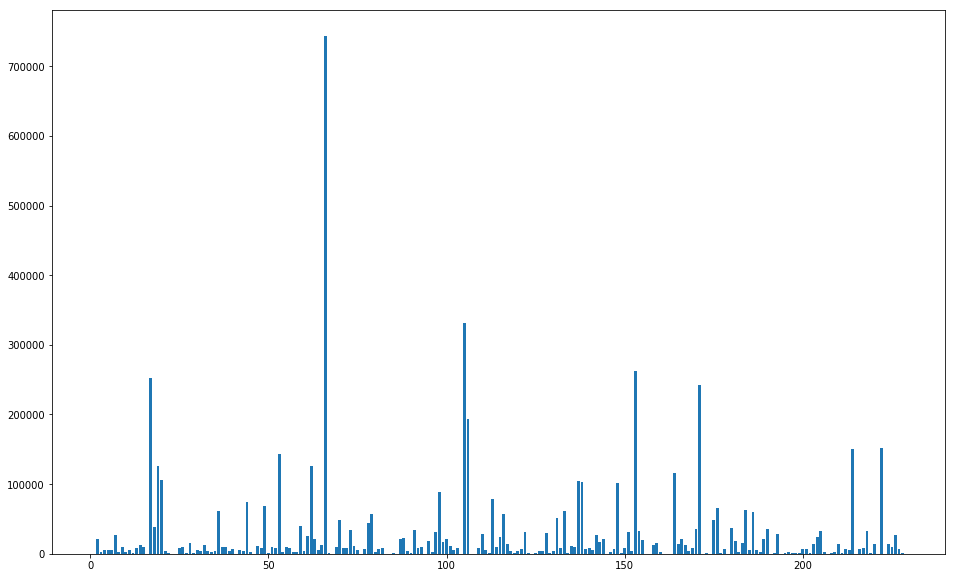

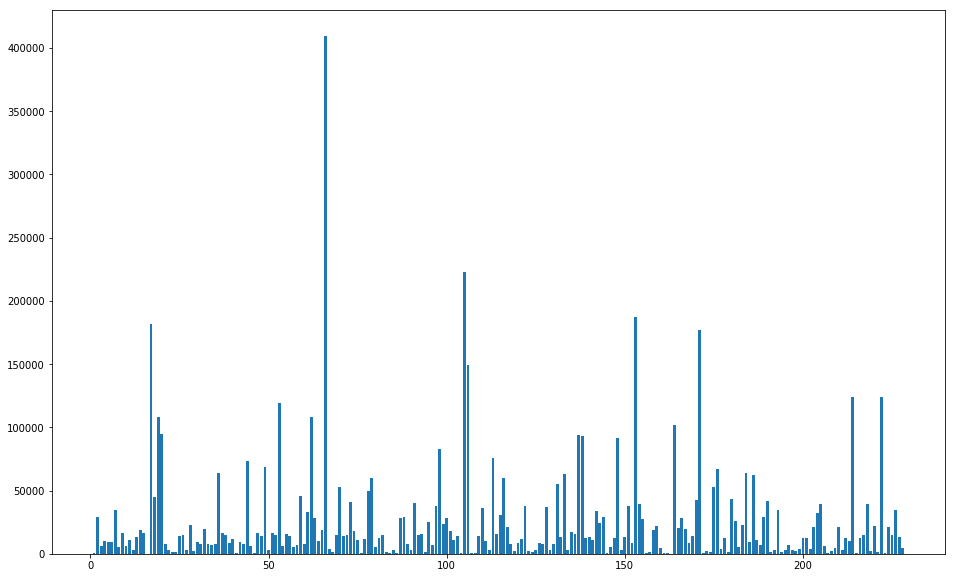

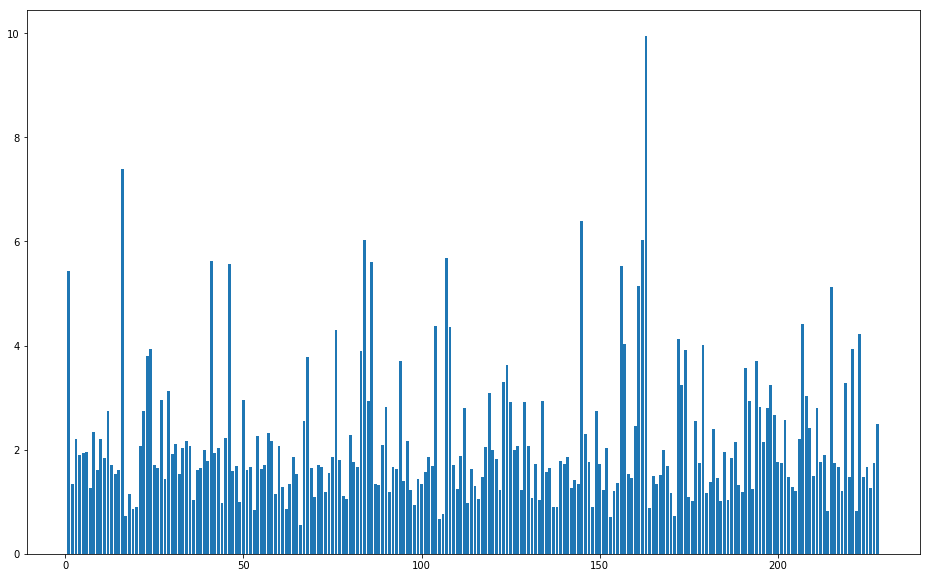

In [40]:
import matplotlib.pyplot as plt

def plot_kv(kv_map):
    keys, values = zip(*kv_map.items())
    plt.figure(figsize=(16, 10))
    plt.bar(keys, values)

train_label_to_weight_map = normalize_label_to_freq_map(train_label_to_freq_map)
assert len(train_label_to_weight_map) == 228
plot_kv(train_label_to_freq_map)
plot_kv({
    label: weight * train_label_to_freq_map[label]
    for label, weight in train_label_to_weight_map.items()
})
plot_kv(train_label_to_weight_map)

In [48]:
# Sanity check:
# for labels with smaller weights, their freq should be large.
train_label_to_small_weight_map = {
    label : weight
    for label, weight in train_label_to_weight_map.items()
    if weight < 1
}
print('#labels with weight < 1:', len(train_label_to_small_weight_map))
print('freq for labels with small weight:',
      [train_label_to_freq_map[label] for label in train_label_to_small_weight_map])

print('\n')

train_label_to_large_weight_map = {
    label : weight
    for label, weight in train_label_to_weight_map.items()
    if weight > 5
}
print('#labels with weight > 1:', len(train_label_to_large_weight_map))
print('freq for labels with large weight:',
      [train_label_to_freq_map[label] for label in train_label_to_large_weight_map])

#labels with weight < 1: 19
freq for labels with small weight: [743250, 104064, 105359, 75053, 150814, 330864, 261844, 102957, 116033, 243038, 193283, 142948, 151339, 78011, 251869, 88828, 126473, 126335, 101464]


#labels with weight > 1: 13
freq for labels with large weight: [99, 79, 69, 98, 52, 52, 66, 71, 68, 23, 73, 41, 7]


In [49]:
import json
with open('../data/train_label_to_weight_map.json', 'w') as fout:
    json.dump(train_label_to_weight_map, fout)

# train_labels_count_to_weight_map

In [52]:
unique_labels_count = set(
    len(annotation['labelId'])
    for annotation in train_json['annotations']
)

print(unique_labels_count)

train_labels_count_to_weight_map = {
    labels_count : 1.0
    for labels_count in unique_labels_count
}

with open('../data/train_labels_count_to_weight_map.json', 'w') as fout:
    json.dump(train_labels_count_to_weight_map, fout)

{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23}
